**Table of contents**<a id='toc0_'></a>    
- [Solving for the stationary equilibrium in the HANC model](#toc1_)    
  - [Obtain the policy function with EGM](#toc1_1_)    
  - [Obtain the distribution using the histogram method](#toc1_2_)    
  - [Obtain aggregate hh variables using policies and the distribution](#toc1_3_)    
  - [Put everything together: solve for the steady-state in GE](#toc1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [123]:
import numpy as np
import numba as nb 
from consav.linear_interp import interp_1d_vec
from EconModel import jit
from HANCModel import HANCModelClass
import matplotlib.pyplot as plt
from consav.grids import equilogspace
from consav.markov import log_rouwenhorst

These notes are inspired by and draw upon the lecture notes of Matthew Rognlie, (available at this [link](https://github.com/shade-econ/nber-workshop-2023/tree/main)) which served as the original reference. I gratefully acknowledge his work and contribution as the foundation for this material.

# <a id='toc1_'></a>[Solving for the stationary equilibrium in the HANC model](#toc0_)

This notebook explains how to solve for the stationary equilibrium in the HANC model without the use of the GEModelTools. 

First, let us create a class that contains the necessary parameters to solve the model. 

In [124]:
class Parameters:
    def __init__(self):
        # preferences
        self.beta = 0.966
        self.sigma = 2.0
        
        # production
        self.alpha = 1/3
        self.delta = 0.008
        self.Gamma = 0.4
        
        # grids
        self.Na = 500
        self.a_min = 0.0
        self.a_max = 10_000.0 
        self.a_grid = equilogspace(self.a_min,self.a_max,self.Na)

        # income
        self.rho_z = 0.975
        self.sigma_psi = 0.5
        self.Nz = 6
        self.z_grid, self.z_trans,self.z_ergodic,_,_ = log_rouwenhorst(self.rho_z,self.sigma_psi,self.Nz)
        

par = Parameters()

In [125]:
par.z_trans[0,0]

0.9390430905151369

In [126]:
par.z_ergodic

array([0.03125, 0.15625, 0.3125 , 0.3125 , 0.15625, 0.03125])

In [127]:
np.sum(par.z_grid * par.z_ergodic)

1.0

## <a id='toc1_1_'></a>[Obtain the policy function with EGM](#toc0_)

The first step is to use the endogenous-grid method (EGM) to obtain the policy function for savings and consumption. 

The `solve_hh_backwards_one_step` implements one step of the EGM algorithm: given a guess on `vbeg_a`, the derivative of the value function, it returns policies for `a, c` and updates `vbeg_a`, taking prices $r$ and $w$ as given.

In [128]:
w = 1 
r = 0.05 

Lets's go in the detail about the EGM algorithm. 

Our goal is to obtain the policy functions $a'(a,z)$ and $c(a,z)$ for each point on the grids `a_grid` and `z_grid`. 

The standard method to do this if VFI: guess a value function $V(a,z)$, and iterate over the RHS of the Bellman equation $V^n(a,z)=(\max_{a'}\{u(c)+\beta \mathbb{E}[V^{n-1}(a',z')]\}$ until $V^n(a,z)\approx V^{n-1}(a,z)$. 

The issue with this method is that for each point $(a,z)$ on our grids, we need to run an optimization algorithm (like the golden-search algorithm), which is costly. 

The endogenous grid-method of Caroll proposes to iterate over the Euler equation instead.

First, recall that the first-order condition of the problem writes $u'(c)=\beta W'(a',z)$ where $W(a',z)=\mathbb{E}_z[V(a',z')]$. Our first step is thus to define an initial guess for $V_a$. 

In [129]:
y = w*par.z_grid
c = r*par.a_grid[np.newaxis,:] + y[:,np.newaxis]  # implied guess on a'(a,z)=a
Va = (1+r)*c**(-par.sigma) # use the envelope condition to get derivative of value function implied by our guess on the policy function
Wa = par.z_trans @ Va # Take expectation using matrix multiplication

$$u'(c) = \beta W'(a',z)$$

Instead of fixing a grid over $a$, we now set a grid over $a'$. We can set use the FOC to obtain $c$ as a function of $a'$:
$c(a',z)=u'^{-1}[\beta W'(a',z)]$. 

In [130]:
# FIRST STEP
Nz, Na = Wa.shape
a = np.zeros((Nz, Na))
c_endo = np.zeros((Nz, Na)) 

# a. solve step
for i_z in range(Nz):
    ## i. get c(a',z)
    # Note that Wa[i_z] is a vector of size Na
    c_endo[i_z] = (par.beta*Wa[i_z])**(-1/par.sigma) # invert the FOC to obtain c(a',z)

In [131]:
c_endo.shape

(6, 500)

We also know that, from the budget constraint, we must have
$$a'+c(a',z)=a(1+r)+wz.$$
Note that in this equation, $a'$ and $z$ are defined on their grids, and we also know $c(a',z)$. We can thus invert it to obtain
$$
a(a',z) = \frac{a'+c(a',z)-wz}{1+r}
$$ 
where $a(a',z)$ is the *endogenous grid* for assets, hence the name of the method.

We are reversing the problem: instead of finding the optimal $a'$ given states $(a,z)$, we are asking: what is the $a$ today that would make it optimal to choose $a'$, given the Euler equation? 

Of course, we are eventually interested in $a'(a,z)$. To do so, we can invert our function $a(a',z)$ by using interpolation on the grid `a_grid`. That is, we interpolate the function $a'(a_{endo},z)$ on the point $a_{grid}$ which gives us $a'(a,z)$. 

In [132]:
for i_z in range(Nz):
    # ii. compute a_endo = (c(a',z) + a' - y) / (1+r)
    a_endo = (c_endo[i_z] + par.a_grid-par.z_grid[i_z]) / (1+r) # get a(a',z) by inverting the budget constraint

    # iii. interpolation to fixed grid
    interp_1d_vec(a_endo,par.a_grid,par.a_grid, a[i_z]) # interpolate the function a'(a_endo, z) on the points a_grid to get a'(a,z)

The last thing to note is that, due to the borrowing constraint, some points $a'(a,z)$ implied by the FOC are not feasible and violate the borrowing constraint. We just impose them by setting $a'(a,z)=0$. 

In [133]:
for i_z in range(Nz):
    a[i_z,:] = np.fmax(a[i_z,:],0.0) # enforce borrowing constraint

We then can compute $c(a,z)$ as the residual of the budget constraint, and use the envelope condition to update our guess on the derivative of the value function
$$V^n_a=(1+r)c(a,z)^{-\sigma}$$
and compute the expectation using the Markov transition matrix.

In [134]:
for i_z in range(Nz):
    c[i_z] = (1+r)*par.a_grid + w*par.z_grid[i_z]-a[i_z] # Get consumption from the budget constraint
RHS = (1+r)*c**(-par.sigma) # get the derivative of the value function from the FOC
vbeg_a_new = par.z_trans @ RHS # 

We then put all of this in one function, and iterate until convergence.

Algorithm:
Guess a function $V^{'n}(a,z)$
1. Back out consumption implied $c(a',z)=u^{'-1}(\mathbb{E}_t[V'(a',z')])$ 
2. Get an **endogenous grid** for assets using the budget constraint: $a_{endo}(a',z)=\frac{a'+c(a',z)-zw}{1+r}$ 
3. This gives you $a'(a_{endo},z)$. Put it back on the exogenous grid by interpolation 
4. Impose the non-borrowing constraint by fixing $a'(a,z)<0$ to 0 
5. Back out consumption using the budget constraint: $c(a,z)=a(1+r)+wz-a'(a,z)$ 
6. Update your guess on the derivative of the value function using the envelope condition: $V^{'n+1}=u'(c)(1+r)$
Iterate until convergence

In [135]:
def solve_hh_backwards_one_step(z_trans, z_grid, a_grid, sigma, beta, r, w, vbeg_a):

    Nz, Na = vbeg_a.shape
    a = np.zeros((Nz, Na))
    c = np.zeros((Nz, Na)) 
    
    # a. solve step
    for i_z in range(Nz):
    
        ## i. get c(a',z)
        c_endo = (beta*vbeg_a[i_z])**(-1/sigma)
        
        # ii. compute a_endo = (c(a',z) + a' - z) / (1+r)
        a_endo = (c_endo + a_grid-w*z_grid[i_z]) / (1+r) 

        # iii. interpolation to fixed grid
        a[i_z] = np.interp(a_grid, a_endo, a_grid) # we interpolate the function a'(a_endo) at the point a_grid, which gives us a'(a_grid)!
        a[i_z,:] = np.fmax(a[i_z,:],0.0) # enforce borrowing constraint
        c[i_z] = (1+r)*a_grid + w*z_grid[i_z] - a[i_z]

    # b. expectation step
    RHS = (1+r)*c**(-sigma)
    vbeg_a_new = z_trans @ RHS

    return c, a, vbeg_a_new


Then, for a given $r$, $w$, we can loop over this step until convergence, that is, until the `vbeg_a` we feed into the function is arbitrarily close to the `vbeg_a_new` that it outputs.

In [136]:
w = 0.723408276673697
r = 0.0117958248643717

In [137]:
def egm_ss(r, w, par, max_iter = 10_000, tol = 1e-8, verbose = False):
    """ solve the EGM for the steady state """

    # a. initialize
    y = w*par.z_grid
    c = r*par.a_grid[np.newaxis,:] + y[:,np.newaxis] 
    Va = (1+r)*c**(-par.sigma)

    # b. iterate
    for it in range(max_iter):

        # i. solve backwards
        c, a, Va_new = solve_hh_backwards_one_step(par.z_trans, par.z_grid, par.a_grid, par.sigma, par.beta, r, w, Va)

        # ii. check convergence
        error = np.max(np.abs(Va - Va_new))
        if verbose:
            print(error)
        if error < tol:
            break

        Va = Va_new.copy()

    return c, a, Va_new

c, a, Va = egm_ss(r, w, par, verbose = True)


234258.44255210226
210684.64291104535
188139.72246492468
167114.67395429267
147773.011257204
130182.95168179786
114339.35730800172
100183.26250482327
87618.86639724136
76527.66861607833
68838.43950445717
61947.900661126594
55626.48465963034
49837.349971712916
44549.643555922084
39735.63759373757
35368.756884542294
31422.40775543393
27869.454935754533
24824.12391831982
22360.40981618868
20095.02270825504
18018.865319555043
16123.033415734593
14398.40356102027
12835.435576887394
11471.178882069362
10332.12839865411
9284.997587974882
8326.20017582021
7451.805438910262
6657.4989826263045
5990.8058854952105
5390.991785308026
4840.689034558716
4337.87436782982
3889.8499309243343
3506.1198508218513
3153.0459024476586
2829.5906214628776
2543.2050788553024
2292.7827027142193
2062.3118846250727
1851.3192569957027
1671.5829177597334
1505.694623966774
1353.3015285110305
1222.6370987679256
1102.0260238537157
992.7327949225146
896.9963167832757
808.5209620123933
730.523149012959
659.7077686061457
59

In [138]:
print(par.z_grid[-1])
print(par.a_grid[5])
print(c[-1,5])

17.091392104386966
0.028005215164874808
2.122882768669113


That's it! We have obtains the policy functions for consumption and savings of the households at the steady state for a given $r$ and $w$ (i.e. in partial equilibrium). We can plot those for given $(a,z)$. 

As expected, the consumption function is a concave function of wealth, and the net-savings function is a decreasing function of wealth, crossing the 0 horizontal line (implying a buffer-stock behavior).

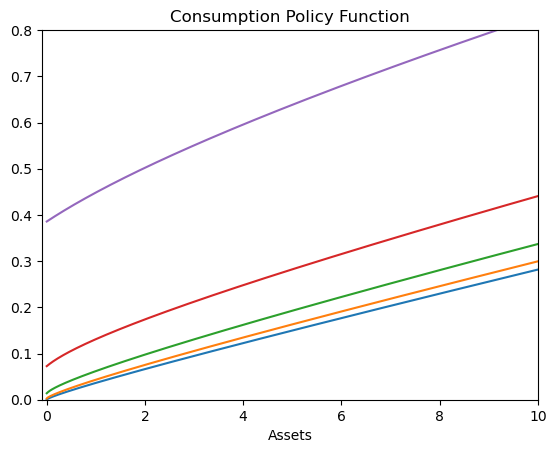

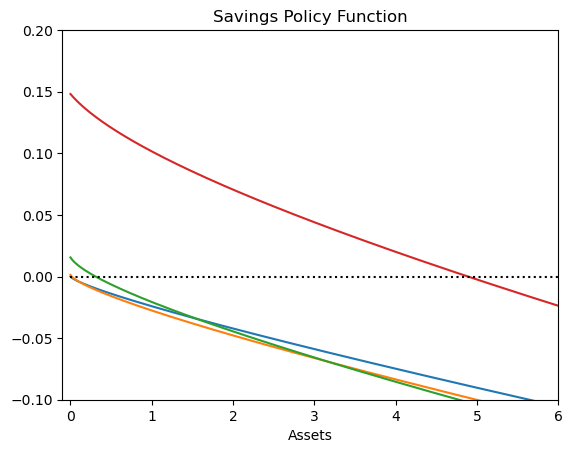

In [139]:
plt.plot(par.a_grid, c.T)
plt.xlim(-0.1, 10)
plt.ylim(0, 0.8)
plt.title('Consumption Policy Function')
plt.xlabel('Assets')
plt.show()

plt.plot(par.a_grid, (a-par.a_grid[np.newaxis,:]).T)
plt.plot(par.a_grid, np.zeros_like(par.a_grid), linestyle = ':', color = 'black')
plt.xlim(-0.1, 6)
plt.ylim(-0.1, 0.2)
plt.title('Savings Policy Function')
plt.xlabel('Assets')
plt.show()

## <a id='toc1_2_'></a>[Obtain the distribution using the histogram method](#toc0_)

The second part of this course is to compute the distribution. Our goal is to simulate the households in the economy in order to compute the distribution and the relevant aggregage variables. 

A first method to do this is the Monte-Carlo method: simulate $N$ households with initial conditions $(a_0,z_0)$ for $T$ periods using the policy functions and drawing shocks for each period. Because of the law of large number, if $T$ is large enough, the distribution will converge to its stationary distribution. However, this method is quite slow because for each $(i,t)$, we need to interpolate over the policy function and draw some new shocks for $z'$. It will also require a large $N$ for the law of large number to kick in.

Instead, we may use the histogram method (also sometimes called Young's method). The idea is to approximate a distribution $D(a,z)$ over our existing grids `a_grid`, `z_grid`. 

In [140]:
D = np.zeros((Nz, Na))
D[0,0] = 1.0 # initialize all households to be a z = z_min, a = a_min

One difficulty is that our policy function $a'(a,z)$ implies decisions that are most likely not on the grid for `a_grid`. For example, `a'[5,0]` is located between the points 16 and 17.

In [141]:
print(par.a_grid)
print(par.z_grid)

[0.00000000e+00 5.36571876e-03 1.08466013e-02 1.64451193e-02
 2.21637976e-02 2.80052152e-02 3.39720064e-02 4.00668620e-02
 4.62925309e-02 5.26518204e-02 5.91475986e-02 6.57827949e-02
 7.25604016e-02 7.94834752e-02 8.65551378e-02 9.37785787e-02
 1.01157055e-01 1.08693895e-01 1.16392498e-01 1.24256334e-01
 1.32288951e-01 1.40493971e-01 1.48875094e-01 1.57436101e-01
 1.66180851e-01 1.75113288e-01 1.84237442e-01 1.93557426e-01
 2.03077443e-01 2.12801788e-01 2.22734845e-01 2.32881094e-01
 2.43245110e-01 2.53831568e-01 2.64645242e-01 2.75691009e-01
 2.86973849e-01 2.98498852e-01 3.10271214e-01 3.22296245e-01
 3.34579368e-01 3.47126122e-01 3.59942165e-01 3.73033278e-01
 3.86405363e-01 4.00064452e-01 4.14016704e-01 4.28268412e-01
 4.42826002e-01 4.57696040e-01 4.72885231e-01 4.88400427e-01
 5.04248623e-01 5.20436967e-01 5.36972759e-01 5.53863457e-01
 5.71116678e-01 5.88740203e-01 6.06741979e-01 6.25130125e-01
 6.43912934e-01 6.63098875e-01 6.82696602e-01 7.02714953e-01
 7.23162955e-01 7.440498

In [142]:
a_i = np.searchsorted(par.a_grid, a[5,0], side='right') -1

print(a[5,0])
print(par.a_grid[a_i])
print(par.a_grid[a_i+1])

10.242771438051957
10.027623664055108
10.248211016525165


In [143]:
print(a_i)

175


To solve this problem, we will discretize our policy function, and use the 'lottery method' to distribute households to the points surrounding $a'(z,a)$. 

First, we obtain all the indexes on our grid such that, for all $a'(a,z)$, we find `a_i` where `a_grid[a_i]` is the point on the grid just below `a'` and `a_grid[a_i+1]` is the point just above. We can do this quickly using the `searchsorted` function from numpy.

We will distribute households in this way:
`a_pi = (a_grid[a_i+1] - a)/(a_grid[a_i+1] - a_grid[a_i])`
if `a=a_grid[a_i]` we put a mass one on `a_grid[a_i]`. If `a=a_grid[a_i+1]`, we put a mass one on `a_grid[a_i+1]`. Otherwise, we put more weight on the point on the grid closer to $a'(a,z)$. 

In [144]:

a_pi = (par.a_grid[a_i+1] - a[5,0])/(par.a_grid[a_i+1] - par.a_grid[a_i])
print(a[5,0])
print(a_pi)

10.242771438051957
0.024659521102626945


We then write the `get_lottery` function that performs this discretization for all points on the grids.

In [145]:
def get_lottery(a, a_grid):
    # step 1: find the i such that a' lies between gridpoints a_i and a_(i+1)
    a_i = np.searchsorted(a_grid, a, side='right') - 1
    a_i = np.clip(a_i, 0, len(a_grid)-2)

    # step 2: implement (8) to obtain lottery probabilities pi
    a_pi = (a_grid[a_i+1] - a)/(a_grid[a_i+1] - a_grid[a_i])
    
    return a_i, a_pi


We can now iterate over our discretize policy to compute the distribution next period, when we iterate once over the policy function.

In [146]:
@nb.njit
def forward_policy(D, a_i, a_pi):
    Dend = np.zeros_like(D)
    for z in range(a_i.shape[0]):
        for a in range(a_i.shape[1]):
            # send pi(z,a) of the mass to gridpoint a_i(z,a)
            Dend[z, a_i[z,a]] += a_pi[z,a]*D[z,a]

            # send 1-pi(z,a) of the mass to gridpoint a_i(z,a)+1
            Dend[z, a_i[z,a]+1] += (1-a_pi[z,a])*D[z,a]

    return Dend

To account for the idiosyncratic shock, we apply the transpose of our Markov matrix to the distribution.

In [147]:
def forward_iteration(D, z_trans, a_i, a_pi):
    Dend = forward_policy(D, a_i, a_pi)    
    return z_trans.T @ Dend # (Nz, Nz) x (Nz, Na)

What does this do, in practice?

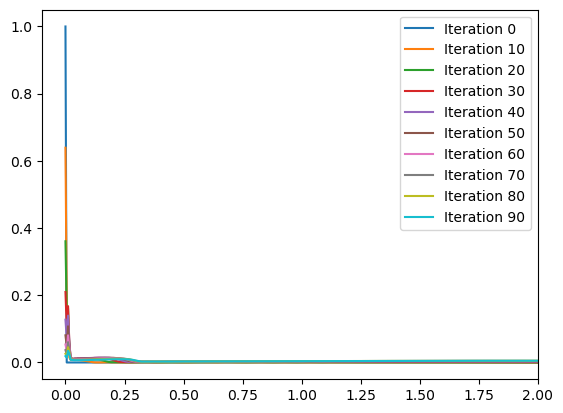

In [148]:
a_i, a_pi = get_lottery(a, par.a_grid)

D = np.zeros((Nz, Na))
D[0,0] = 1.0
for i in range(100):
    D_new = forward_iteration(D, par.z_trans, a_i, a_pi)
    if i%10==0:
        plt.plot(par.a_grid, np.sum(D_new, axis=0), label=f'Iteration {i}')
        plt.xlim(-0.1, 2)
        plt.legend()
    D = D_new

We then iterate over this mapping until convergence!

In [149]:
def distribution_ss(a, par, tol=1E-10, verbose=False):
    a_i, a_pi = get_lottery(a, par.a_grid)

    # as initial D, use stationary distribution for s, plus uniform over a
    D = par.z_ergodic[:, np.newaxis] * np.ones_like(par.a_grid) / len(par.a_grid)

    # now iterate until convergence to acceptable threshold
    for _ in range(100_000):
        D_new = forward_iteration(D, par.z_trans, a_i, a_pi)
        error = np.max(np.abs(D_new - D))
        if verbose:
            print(error)
        if error < tol:
            return D_new
        D = D_new

In [150]:
D = distribution_ss(a, par, verbose = True)

0.001383898999845741
0.0022323852703638857
0.0027579429376164404
0.0033889773665600267
0.00355817230027244
0.004241199837490107
0.003744224884925981
0.004055393497040297
0.0038093931060701183
0.003990289266638872
0.0038308239670318666
0.003897124406884881
0.003451501568527895
0.003344603635901307
0.003326940069881203
0.0029795125296499868
0.0027186170372352197
0.002383012401221248
0.002168685779047966
0.002196784318659744
0.002095892723026591
0.0018227510839978717
0.0014271065236406138
0.0013577327812702804
0.0011049228402652106
0.0009957879103548574
0.0009142137826450901
0.0007941234393039089
0.0006777153962137497
0.0006407959910111004
0.0006163370950271962
0.000587908219080677
0.0005615266447363677
0.0005466737549205884
0.0005118251489525246
0.0004599404409817802
0.000394086063126456
0.00035796406168535073
0.0003405943834727523
0.0003083230694946738
0.00026024461410578486
0.00021709205961066786
0.00020545050669892417
0.0001767364512378876
0.00014799542391482636
0.00013843150993184876

One very important thing to understand is that, also the *distribution* is stationary, households move within this distribution at every period. However, because of the law of large numbers, each move perfectly compensate each other so that the distribution remain the same.

In [151]:
np.sum(D[:,0])

0.00034763553068927654

In [152]:
D[0,0]

0.000284452739315955

In [153]:
par.z_grid

array([7.28504207e-04, 5.45131325e-03, 4.07915505e-02, 3.05238484e-01,
       2.28406450e+00, 1.70913921e+01])

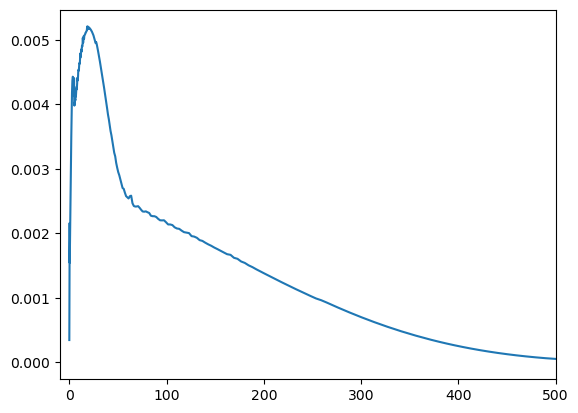

In [154]:
D_flat = np.sum(D, axis = 0)
plt.plot(par.a_grid, D_flat)
plt.xlim(-10, 500)
plt.show()

It's often a good idea to check that we have no households at the very top of our grid to make sure we choose a large-enough upper bound for `a_grid`.

In [155]:
D_flat[-1]

0.0

In [156]:
assert np.isclose(D_flat[-1], 0)

We can also check that it sums to 1.

In [157]:
assert np.isclose(np.sum(D_flat), 1)

The last step is then to compute aggregate variables. We can do this easily by simply by integrating the policy functions over the distribution (i.e. summing, in our discrete world)

In [158]:
A = np.sum(a*D)
C = np.sum(c*D)

In [159]:
print(A)
print(C)

31.677885033811027
1.0970751044998046


And that's it! We have seen how to:
1. Compute the policy functions of the households for a given $(r,w)$ 
2. And to compute the associated stationary distribution.
3. How to compute the aggregate variables of the household block

Now, let's move to solving the general equilibrium.

## <a id='toc1_3_'></a>[Obtain aggregate hh variables using policies and the distribution](#toc0_)

In [160]:
def household_ss(r, w, par, max_iter = 10_000, tol = 1e-8, verbose = False):
    # 1. backward step: EGM
    c, a, Va = egm_ss(r, w, par, max_iter, tol, verbose) 
    #. 2. forward step: distribution
    D = distribution_ss(a, par)
    # 3. aggregate
    A = np.sum(D * a)
    C = np.sum(D * c) 
    return A, C, D, a, c, Va 


In [161]:
def firm(K, Gamma, par): 
    r = par.alpha * Gamma * K**(par.alpha-1) - par.delta
    Y = Gamma * K**par.alpha 
    w = (1-par.alpha) * Y  
    return r, w, Y

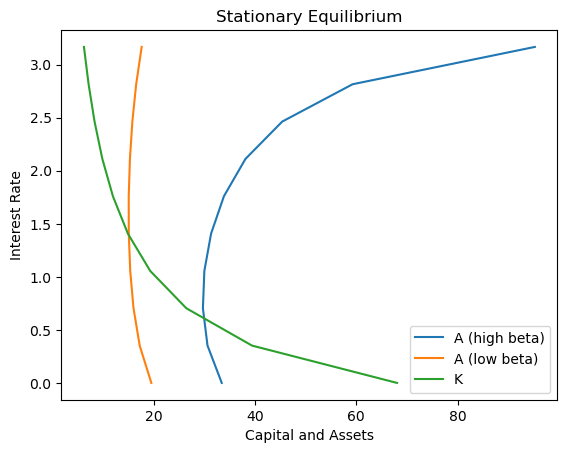

In [162]:
def asset_supply_r(r_vec, beta):
    par.beta = beta 
    Nr = len(r_vec)
    K_vec = ((r_vec+par.delta) / (par.alpha * par.Gamma))**(1/(par.alpha-1))
    Y = par.Gamma * K_vec**par.alpha
    w_vec = (1-par.alpha) * Y
    A_vec = np.zeros(Nr)
    for i, r in enumerate(r_vec):
        print
        A_vec[i], _, _, _, _, _  = household_ss(r_vec[i], w_vec[i], par) 
    return A_vec, K_vec

Nr = 10
r_vec = np.linspace(0.0, (1/par.beta-1)*0.9, Nr)
A_vec, K_vec = asset_supply_r(r_vec, par.beta)
A_vec_2, _ = asset_supply_r(r_vec , par.beta * 0.98)
plt.plot(A_vec, r_vec * 100, label = 'A (high beta)')
plt.plot(A_vec_2, r_vec * 100, label = "A (low beta)")
plt.plot(K_vec, r_vec * 100, label = 'K')
plt.xlabel('Capital and Assets')
plt.ylabel('Interest Rate')
plt.title('Stationary Equilibrium')
plt.legend()

## <a id='toc1_4_'></a>[Put everything together: solve for the steady-state in GE](#toc0_)

In [163]:
def find_ss(K, par):
    r, w, Y = firm(K, par.Gamma, par) 
    A, _, _, _, _, _  = household_ss(r, w, par) 
    print(A-K)
    return A-K

from scipy.optimize import brentq 

K = brentq(find_ss, 5.0, 50.0, args=(par,))
print('Equilibrium K = ', K)
r, w, Y = firm(K, par.Gamma, par)
print('Equilibrium r = ', r*100)
print('Equilibrium w = ', w)

15.539297772786668
-31.90687227928163
-4.3921241018846615
-1.3857154282626816
-0.0841800136196369
-0.001782308745916339
-2.3421029986536723e-06
-6.45581366143233e-11
5.684341886080802e-14
-8.22453216642316e-13
Equilibrium K =  15.028099782841128
Equilibrium r =  1.3894549986398486
Equilibrium w =  0.6580669637919988
